## Data Models

In [7]:
from typing import List
from typing import Callable
from typing import Tuple

class Rectangle:
    
    def __init__(self, width=0, height=0, x=0, y=0, ident=1):
        self.width = width
        self.height = height
        self.x = x
        self.y = y
        self.ident = ident
        self.centerX = x+width/2
        self.centerY = y+height/2
    
    def __str__(self):
        return f'{self.ident}: ({self.width},{self.height},{self.x},{self.y}) whxy'
    
def decodeIntList(lst: List[str]) -> List[int]:
    return list(map(int, lst))

def decodeFloatList(lst: List[str]) -> List[float]:
    return list(map(float, lst))

def decodeRectangles(lst: List[str], idents: List[str]) -> List[Rectangle]:
    return list(map(decodeRectangle, *(lst,idents)))

def decodeRectangle(rec: str, ident: str) -> Rectangle:
    x,y,w,h = rec.split(',')
    return Rectangle(x=int(x), y=int(y), width=int(w), height=int(h), ident=ident)


class Individual:
    def __init__(self, iteration: int, objectiveValue: int, paintingSeq: List[int], paintingSeqDecoded: List[int], paintingSeqRandomKey: List[float], slicingOrderDecoded: List[int], slicingOrderRandomKey: List[float], orientations: List[str], orientationsCapped: List[str], orientationsResolved: List[str], paintingAllocatedSpace: List[Rectangle], paintingPlacement: List[Rectangle]):
        self.iteration = iteration
        self.objectiveValue = objectiveValue
        self.paintingSeq = paintingSeq
        self.paintingSeqDecoded = paintingSeqDecoded
        self.paintingSeqRandomKey = paintingSeqRandomKey
        self.slicingOrderDecoded = slicingOrderDecoded
        self.slicingOrderRandomKey = slicingOrderRandomKey
        self.orientations = orientations
        self.orientationsCapped = orientationsCapped
        self.orientationsResolved = orientationsResolved
        self.paintingAllocatedSpace = paintingAllocatedSpace
        self.paintingPlacement = paintingPlacement
        
    @staticmethod
    def create(json: dict) -> 'Individual':
        return Individual(
            iteration=int(json['iteration']),
            objectiveValue=float(json['objectiveValue']),
            paintingSeq=decodeIntList(json['paintingSeq']),
            paintingSeqDecoded=decodeIntList(json['paintingSeqDecoded']),
            paintingSeqRandomKey=decodeFloatList(json['paintingSeqRandomKey']),
            slicingOrderDecoded=decodeIntList(json['slicingOrderDecoded']),
            slicingOrderRandomKey=decodeFloatList(json['slicingOrderRandomKey']),
            orientations=json['orientations'],
            orientationsCapped=json['orientationsCapped'],
            orientationsResolved=json['orientations'], # TODO provide resolved orientations
            paintingAllocatedSpace=decodeRectangles(json['paintingAllocatedSpace_XYWH'], json['paintingSeq']),
            paintingPlacement=decodeRectangles(json['paintingPlacement_XYWH'], json['paintingSeq']))
    
class Painting:
    def __init__(self, ident: str, width: int, height: int):
        self.ident = ident
        self.width = width
        self.height = height
        
    @staticmethod
    def create(json: dict) -> 'Painting':
        return Painting(
            ident=json['ident'],
            width=int(json['width']),
            height=int(json['height']))
    
class HallOfFameRecord:
    def __init__(self, iteration: int, objectiveMin: float, objectiveMax: float, objectiveAvg: float, bestIndividual: Individual):
        self.iteration = iteration
        self.objectiveMin = objectiveMin
        self.objectiveMax = objectiveMax
        self.objectiveAvg = objectiveAvg
        self.bestIndividual = bestIndividual
    
    @staticmethod
    def create(json: dict) -> 'HallOfFameRecord':
        return HallOfFameRecord(
            iteration=int(json['iteration']),
            objectiveMin=float(json['objectiveMin']),
            objectiveMax=float(json['objectiveMax']),
            objectiveAvg=float(json['objectiveAvg']),
            bestIndividual=Individual.create(json['bestIndividual']))
            
class GaResult:
    def __init__(self, bestIndividual: Individual, hallOfFame: List[HallOfFameRecord]):
        self.bestIndividual = bestIndividual
        self.hallOfFame = hallOfFame
        
    @staticmethod
    def create(json: dict) -> 'GaResult':
        return GaResult(
            bestIndividual=Individual.create(json['bestIndividual']),
            hallOfFame=list(map(HallOfFameRecord.create, json['hallOfFame']['records'])))
    
class GaParameters:
    def __init__(self, maxNumberOfIter: int, populationSize: int, geneticAlgorithm: str, mate: str, mutate: str, select: str):
        self.maxNumberOfIter = maxNumberOfIter
        self.populationSize = populationSize
        self.geneticAlgorithm = geneticAlgorithm
        self.mate = mate
        self.mutate = mutate
        self.select = select
        
    @staticmethod
    def create(json: dict) -> 'GaParameters':
        return GaParameters(
            maxNumberOfIter=int(json['maxNumberOfIter']),
            populationSize=int(json['populationSize']),
            geneticAlgorithm=json['geneticAlgorithm'],
            mate=json['mate'],
            mutate=json['mutate'],
            select=json['select'])

class Layout:
    def __init__(self, width: int, height: int, evalFunc: str):
        self.width = width
        self.height = height
        self.evalFunc = evalFunc
        self.boundingRectangle = Rectangle(width=width, height=height, x=0, y=0, ident="")
        
    @staticmethod
    def create(json: dict) -> 'Layout':
        return Layout(width=json['width'], height=json['height'], evalFunc=json['evalFunc'])
    

class InstanceParameters:
    def __init__(self, layout: Layout, paintings: List[Painting]):
        self.layout = layout
        self.paintings = paintings
        
    @staticmethod
    def create(json: dict) -> 'InstanceParameters':
        return InstanceParameters(
            layout=Layout.create(json['layout']),
            paintings=list(map(Painting.create, json['paintings'])))
    
class ObjectiveParameters:
    def __init__(self, name: str, params: dict):
        self.name = name
        self.params = params
        
    @staticmethod
    def create(json: dict) -> 'ObjectiveParameters':
        return ObjectiveParameters(
            name=json['name'],
            params=json['params'])
        

class ComputationResult:
    def __init__(self, applicationVersion: str, createdAt: str, durationMillis: int, gaResult: GaResult, gaParameters: GaParameters, instanceParameters: InstanceParameters, objectiveParameters: ObjectiveParameters, name: str = None):
        self.applicationVersion = applicationVersion
        self.createdAt = createdAt
        self.durationMillis = durationMillis
        self.gaResult = gaResult
        self.gaParameters = gaParameters
        self.instanceParameters = instanceParameters
        self.objectiveParameters = objectiveParameters
        self.name = name
        
    @staticmethod
    def createWithName(name: str, json: dict):
        compRes = ComputationResult.create(json)
        compRes.name = name
        return compRes
    
    @staticmethod
    def create(json: dict) -> 'ComputationResult':
        return ComputationResult(
            applicationVersion=json['applicationVersion'],
            createdAt=json['createdAt'],
            durationMillis=int(json['durationMillis']),
            gaResult=GaResult.create(json['gaResult']),
            gaParameters=GaParameters.create(json['gaParameters']),
            instanceParameters=InstanceParameters.create(json['instanceParameters']),
            objectiveParameters=ObjectiveParameters.create(json['objectiveParameters']))

## Loading computation result

In [8]:
from pathlib import Path
import json

def _getDirPrefix(name: str) -> int:
    return int(name.split('_')[0])

def loadLatestComputationResult(resultDir='/home/slarty/Documents/master-thesis/src/impl/out') -> ComputationResult:
    dirs = [x for x in Path(resultDir).iterdir() if x.is_dir()]
    latest, prefix = dirs[0], _getDirPrefix(dirs[0].name)
    for d in dirs:
        k = _getDirPrefix(d.name)
        if k > prefix:
            latest, prefix = d, k
    return loadComputationResult(str(latest.resolve()))

def loadComputationResult(path: str, compResultFileName='computation_result.json') -> ComputationResult:
    print(f'loading: {path}')
    with open(path + '/' + compResultFileName, 'r') as f:
        data = json.load(f)
    return ComputationResult.createWithName(path.split('/')[-1], data)

## Drawing

### Tree Printer

In [9]:
class SlicingNode:
    def __init__(self, value: str, left: 'SlicingNode' = None, right: 'SlicingNode' = None):
        self.value = value
        self.left = left
        self.right = right
        
def createSlicingNodeOrientationLabel(orientation: str, orientationResolved: str, resolve: bool) -> str:
    if resolve:
        return orientationResolved
    return orientation
    
def decodeToTreeRec(paintingSequence: List[str], slicingOrder: List[int], orientations: List[str], orientationsResolved: List[str], resolve=False) -> SlicingNode:
    if len(paintingSequence) == 1:
        return SlicingNode(value=paintingSequence[0])

    k = slicingOrder[0]
    lp, rp = paintingSequence[:k], paintingSequence[k:]
    
    return SlicingNode(
        value=createSlicingNodeOrientationLabel(orientations[0], orientationsResolved[0], resolve),
        left=decodeToTreeRec(lp, *filterUpTo(slicingOrder, orientations, orientationsResolved, k), resolve),
        right=decodeToTreeRec(rp, *filterAfter(slicingOrder, orientations, orientationsResolved, k), resolve))

def filterUpTo(slicingOrder: List[int], orientations: List[str], orientationsResolved: List[str], k: int) -> Tuple[List[int], List[str], List[str]]:
    slicingOrderNew, orientationsNew, orientationsResolvedNew = [], [], []
    for x,y,z in zip(slicingOrder, orientations, orientationsResolved):
        if x < k:
            slicingOrderNew.append(x)
            orientationsNew.append(y)
            orientationsResolvedNew.append(z)
    return slicingOrderNew, orientationsNew, orientationsResolvedNew

def filterAfter(slicingOrder: List[int], orientations: List[str], orientationsResolved: List[str], k: int) -> Tuple[List[int], List[str], List[str]]:
    slicingOrderNew, orientationsNew, orientationsResolvedNew = [], [], []
    for x,y,z in zip(slicingOrder, orientations, orientationsResolved):
        if x > k:
            slicingOrderNew.append(x-k)
            orientationsNew.append(y)
            orientationsResolvedNew.append(z)
    return slicingOrderNew, orientationsNew, orientationsResolvedNew

def computeTraversalRec(node: SlicingNode, depth: int, traversal: List[str]) -> None:
    if node is None:
        return
    computeTraversalRec(node.right, depth+1, traversal)
    traversal.append((depth * '  ' + str(node.value)))
    computeTraversalRec(node.left, depth+1, traversal)
    
def normalizeTraversal(traversal: List[str]) -> List[str]:
    n = max([len(x) for x in traversal])
    traversalNew = []
    for t in traversal:
        traversalNew.append(t + (n-len(t)) * ' ')
    return traversalNew
    
def flipTraversal90(traversal: List[str]) -> List[str]:
    traversalNew = []
    traversal = normalizeTraversal(traversal)
    for i in range(len(traversal[0])):
        acc = ""
        for j in range(len(traversal)-1, -1, -1):
            acc += traversal[j][i]
        traversalNew.append(acc)
    return traversalNew

def computePrintableSlicingTree(res: ComputationResult, resolve=False) -> str:
    root = decodeToTreeRec(
        paintingSequence=res.gaResult.bestIndividual.paintingSeqDecoded,
        slicingOrder=res.gaResult.bestIndividual.slicingOrderDecoded,
        orientations=res.gaResult.bestIndividual.orientationsCapped,
        orientationsResolved=res.gaResult.bestIndividual.orientationsResolved,
        resolve=resolve
    )
    traversal = []
    computeTraversalRec(node=root, depth=0, traversal=traversal)
    traversal =  flipTraversal90(traversal)
    return '\n'.join(traversal)

def printSlicingTree(res: ComputationResult) -> None:
    print(f'\nSlicing tree (unresolved)\n\n{computePrintableSlicingTree(res, resolve=False)}\n\n')
    # print(f'Slicing tree (resolved)\n\n{computePrintableSlicingTree(res, resolve=True)}')

### Graps

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np

def createEvalFunc(funcStr: str) -> Callable[[float, float], float]:
    from pathlib import Path
    import clr 
    dllpath = str(Path('MathParser.org-mXparser.dll').resolve())
    clr.AddReference(dllpath)

    import org.mariuszgromada.math.mxparser as mx
    if not hasattr(createEvalFunc, 'licenseUsed'):
        createEvalFunc.licenseUsed = True
        mx.License.iConfirmNonCommercialUse("Martin Šafránek")
    return mx.Function(funcStr).calculate

def toMatplotlibRec(rec, **kwargs):
    return matplotlib.patches.Rectangle(
        (rec.x, rec.y),
        width=rec.width,
        height=rec.height,
        fill=False,
        **kwargs)

def drawRectangle(
    rec: Rectangle,
    ax,
    show_center=False, show_ident=False, show_func_value=False,
    evalFunc: Callable[[float, float], float]=None,
    **kwargs):
    ax.add_patch(toMatplotlibRec(rec, **kwargs))
    cx, cy = rec.x+rec.width/2, rec.y+(rec.height/2)
    
    if show_center:
        ax.scatter(rec.centerX, rec.centerY, color='black', s=1, alpha=1)
    if show_ident and not show_func_value:
        k = 1.13 if show_center else 1
        ax.text(rec.centerX*k, rec.centerY*k, rec.ident, fontsize=8)
    if show_func_value:
        ax.text(rec.x+0.15*rec.width, rec.y+0.45*rec.height, f'id={rec.ident}\nf={evalFunc(cx,cy):.2f}', fontsize=6)
        
def drawRectangles(
    ax,
    recs: List[Rectangle],
    allocatedSpaceRecs: List[Rectangle],
    grid: Rectangle,
    evalFunc: Callable[[float, float], float]=None,
    show_ident=True, title=None, show_center=False, show_func_value=False):
    
    for rec in allocatedSpaceRecs:
        drawRectangle(rec, ax, edgecolor='grey', linewidth=1.1, alpha=0.8, linestyle='solid',
                      show_center=False, evalFunc=evalFunc, show_func_value=False)
        
    for rec in recs:
        drawRectangle(rec, ax, edgecolor='blue', show_center=show_center, linewidth=1.2,
                      show_ident=show_ident, evalFunc=evalFunc, show_func_value=show_func_value)

    ax.set_xlim(left   =- 1, right =grid.width  +1)
    ax.set_ylim(bottom =- 1, top   =grid.height +1)
    ax.set_title(f'{title or "Slicing layout"}', fontsize=8)
    
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)    
    
    drawRectangle(grid, ax, edgecolor='black', linewidth=1.2)
    # ax.axis('off')
    
def getAxSize(ax):
    """source: unutbu, https://stackoverflow.com/a/19306776/6784881"""
    bbox = ax.get_window_extent()
    width, height = bbox.width, bbox.height
    return width, height

def getAxHeight(ax):
    return getAxSize(ax)[1]
    
def createParameterDigest(res: ComputationResult) -> str:
    return f'alg={res.gaParameters.geneticAlgorithm}, popSize={res.gaParameters.populationSize}'

def hallOfFameStatisticsToDataframe(res: ComputationResult) -> pd.DataFrame:
    data = []
    for hof in res.gaResult.hallOfFame:
        data.append((hof.iteration, hof.objectiveMin, hof.objectiveMax, hof.objectiveAvg))
    return pd.DataFrame(data, columns=['iteration', 'min', 'max', 'avg']).set_index('iteration', inplace=False)
    
def drawHallOfFamePlot(res: ComputationResult, dpi: int) -> None:
    fig, ax = plt.subplots(dpi=dpi)
    hallOfFameStatisticsToDataframe(res).plot(ylabel='objective', title=f'{res.name}', ax=ax)
    ax.title.set_size(10)
    xb, yb = res.gaResult.bestIndividual.iteration, res.gaResult.bestIndividual.objectiveValue
    ax.scatter([xb], [yb], color='black', s=30)
    ax.annotate('best', (xb, yb+0.3*getAxHeight(ax)))
    
def drawEvalFunction(evalFunc: Callable[[float, float], float], xMax: int, yMax: int, ax, delta: float = 0.02, coef: float = 1.005, alpha: float = 0.5) -> None:
    X, Y = np.meshgrid(np.arange(0, xMax*coef, delta), np.arange(0, yMax*coef, delta))
    Z = np.vectorize(evalFunc)(X,Y)
    # ax.contourf(X,Y,Z, alpha=alpha)
    ax.pcolormesh(X,Y,Z, alpha=alpha, shading='auto')

def drawSlicingLayoutPlot(res: ComputationResult, dpi=150) -> None:
    fig, ax = plt.subplots(dpi=dpi)
    evalFunc = createEvalFunc(res.instanceParameters.layout.evalFunc)
    
    drawEvalFunction(
        evalFunc=evalFunc,
        xMax=res.instanceParameters.layout.width,
        yMax=res.instanceParameters.layout.height,
        ax=ax,
        delta=0.5
    )
    drawRectangles(
        ax=ax,
        recs=res.gaResult.bestIndividual.paintingPlacement,
        show_func_value=True,
        evalFunc=evalFunc,
        show_center=False,
        allocatedSpaceRecs=res.gaResult.bestIndividual.paintingAllocatedSpace,
        grid=res.instanceParameters.layout.boundingRectangle,
        title=f'Slicing layout, best individual\nobjective={res.gaResult.bestIndividual.objectiveValue}, iteration={res.gaResult.bestIndividual.iteration}\nEval func {res.instanceParameters.layout.evalFunc}')

### Drawing API

In [11]:
def describeComputationResult(res: ComputationResult, dpi=150) -> None:
    drawHallOfFamePlot(res, dpi=dpi)
    drawSlicingLayoutPlot(res, dpi=dpi)
    plt.show(block=False)
    printSlicingTree(res)

## Results

loading: /home/slarty/Documents/master-thesis/src/impl/out/013_simpleGa_saf10_horizontal_2A34E


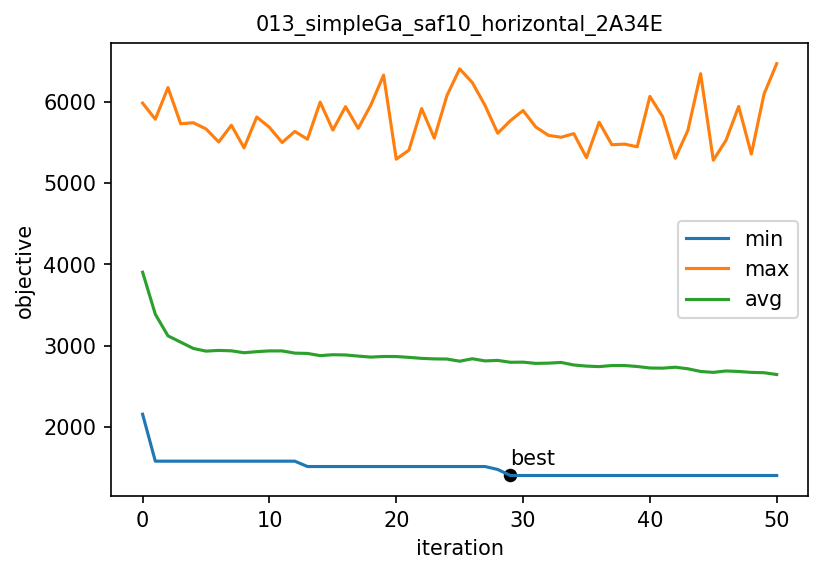

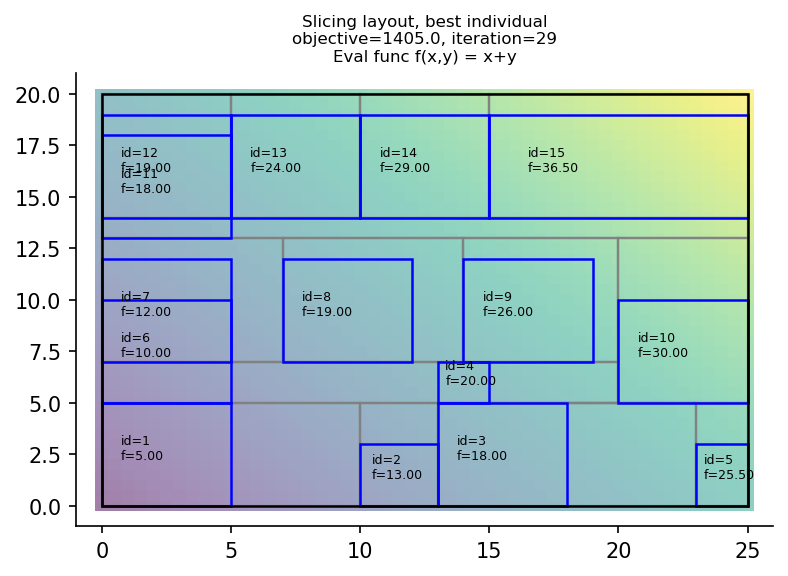


Slicing tree (unresolved)

         H                   
                             
       V             H       
                             
   V    1          H       V 
        3                    
 V   H           V  4  V    1
                            4
9 1 7 8    H      1   3  V   
  5               1          
          6  V          2 1  
                             
            5  V             
                             
              1 1            
              2 0            




In [12]:
latest = loadLatestComputationResult()
describeComputationResult(latest)